<a href="https://colab.research.google.com/github/srilamaiti/SM_MIDS_W207_HW/blob/main/06_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6

This lab connects all the pieces involved in training feed-forward fully connected neural networks. You will run a full set of experiments to explore different hyperparameters and hidden layer sizes for both the MNIST and FASHION_MNIST datasets, and report your findings.

In [ ]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from keras.utils.layer_utils import count_params
from tensorflow.keras import layers
tf.get_logger().setLevel('INFO')

## Datasets


### Fashion MNIST

We load the fashion_mnist dataset as before.

Label: t-shirt


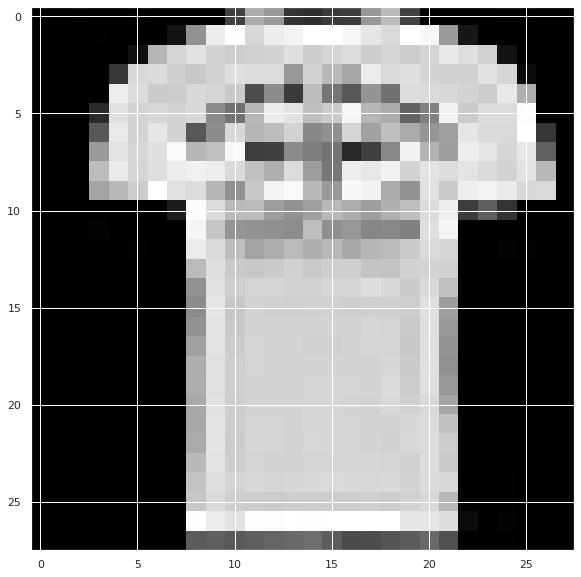

In [ ]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(X_train_fashion, Y_train_fashion), (X_test_fashion, Y_test_fashion) = fashion_mnist.load_data()
X_train_fashion = X_train_fashion / 255.
X_test_fashion = X_test_fashion / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_fashion = Y_train_fashion.flatten()
Y_test_fashion = Y_test_fashion.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_fashion.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_fashion = X_train_fashion[shuffled_indices]
Y_train_fashion = Y_train_fashion[shuffled_indices]

# Show the first training example.
print('Label: %s' %label_names[Y_train_fashion[0]])
plt.imshow(X_train_fashion[0], cmap='gray')
plt.show()

In [ ]:
len(X_train_fashion), len(X_test_fashion), X_train_fashion.shape

(60000, 10000, (60000, 28, 28))

### MNIST

We also load the (digits) mnist dataset in the same way. Note that the number of train/test examples as well as the data shapes are identical to fashion_mnist.

Label: 3


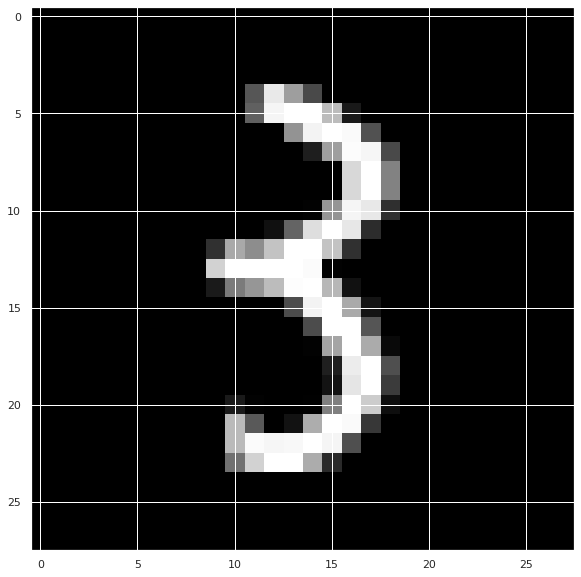

In [ ]:
from keras.datasets import mnist

# Load the MNIST dataset.
(X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = mnist.load_data()
X_train_digits = X_train_digits / 255
X_test_digits = X_test_digits / 255

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_digits = Y_train_digits.flatten()
Y_test_digits = Y_test_digits.flatten()

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_digits.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_digits = X_train_digits[shuffled_indices]
Y_train_digits = Y_train_digits[shuffled_indices]

# Show the first training example.
print('Label: %d' %Y_train_digits[0])
plt.imshow(X_train_digits[0], cmap='gray')
plt.show()

In [ ]:
len(X_train_digits), len(X_test_digits), X_train_digits.shape

(60000, 10000, (60000, 28, 28))

## Build a Model

We will write a build_model function that allows for a range of experiments on both datasets.

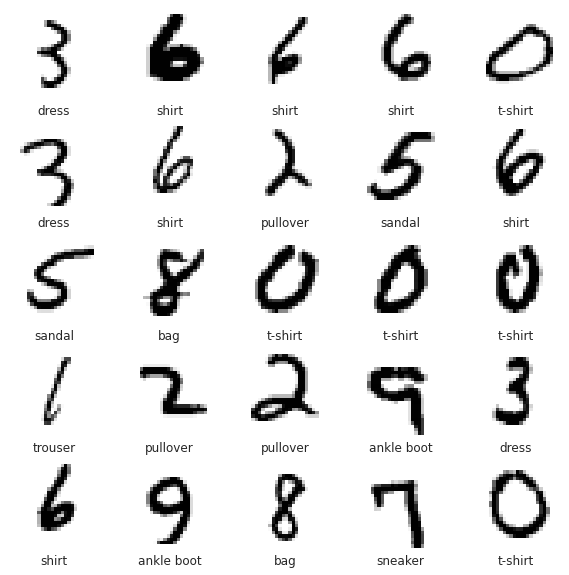

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_digits[i], cmap=plt.cm.binary)
    plt.xlabel(label_names[Y_train_digits[i]])
plt.show()

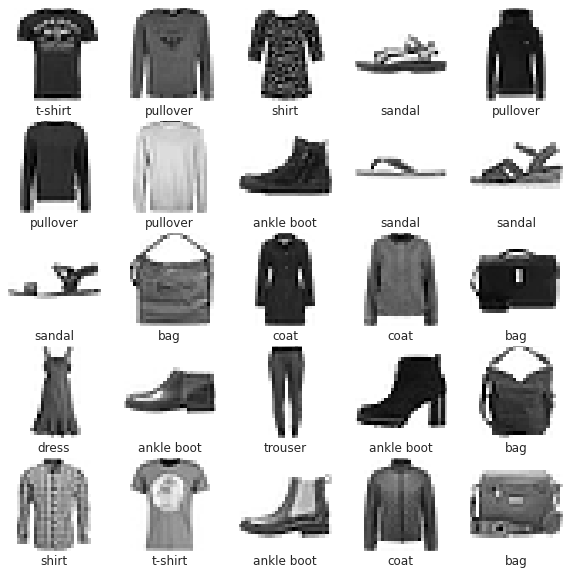

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_fashion[i], cmap=plt.cm.binary)
    plt.xlabel(label_names[Y_train_fashion[i]])
plt.show()

---
### Exercise 1 (58points)

Fill in code that implements the build_model function, including all the arguments listed in the function definition.

In [ ]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation = 'relu',
                optimizer = 'SGD',
                learning_rate = 0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  # YOUR CODE HERE
  layer_list = []
  # first layer: input
  input1 = tf.keras.layers.Flatten(input_shape=(28, 28))
  layer_list.append(input1)
  # In case of no missing layer, we are adding an intermediate layer
  # to apply the activation function. 
  layer_list.append(tf.keras.layers.Dense(units = 784
                                        , activation = activation
                                        , name = 'intermediate_layer'))
  #Adding hidden layers
  for idx, node_cnt in enumerate(hidden_layer_sizes):
      layer_list.append(tf.keras.layers.Dense(units = node_cnt
                                            , activation = activation
                                            , name = 'fc_' + str(idx + 1)))
  
  # Adding output layer
  layer_list.append(tf.keras.layers.Dense(units = n_classes, 
                                          activation = 'softmax', 
                                          name = 'Output'))
  
  model = tf.keras.Sequential(layer_list)
  print(model.summary())
  layers = [layer.output for layer in model.layers]
  print(layers)
  trainable_count = count_params(model.trainable_weights)
  non_trainable_count = count_params(model.non_trainable_weights)
  print(f"Trainable parameters : {trainable_count}")
  print(f"Non-trainable parameters : {non_trainable_count}")
  if optimizer.upper() == 'SGD':
      optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
  elif optimizer.upper() == 'ADAM':
      optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
  
  model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                optimizer = optimizer, 
                metrics=['accuracy'])    
  
  return model

---

## Run Experiments

We can now run a suite of experiments to see how the hyperparameters and layer sizes effect performance. The train_and_evaluate function below can be used to run experiments and retrieve results.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 intermediate_layer (Dense)  (None, 784)               615440    
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'intermediate_layer')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Output')>]
Trainable parameters : 623290
Non-trainable parameters : 0
Training.

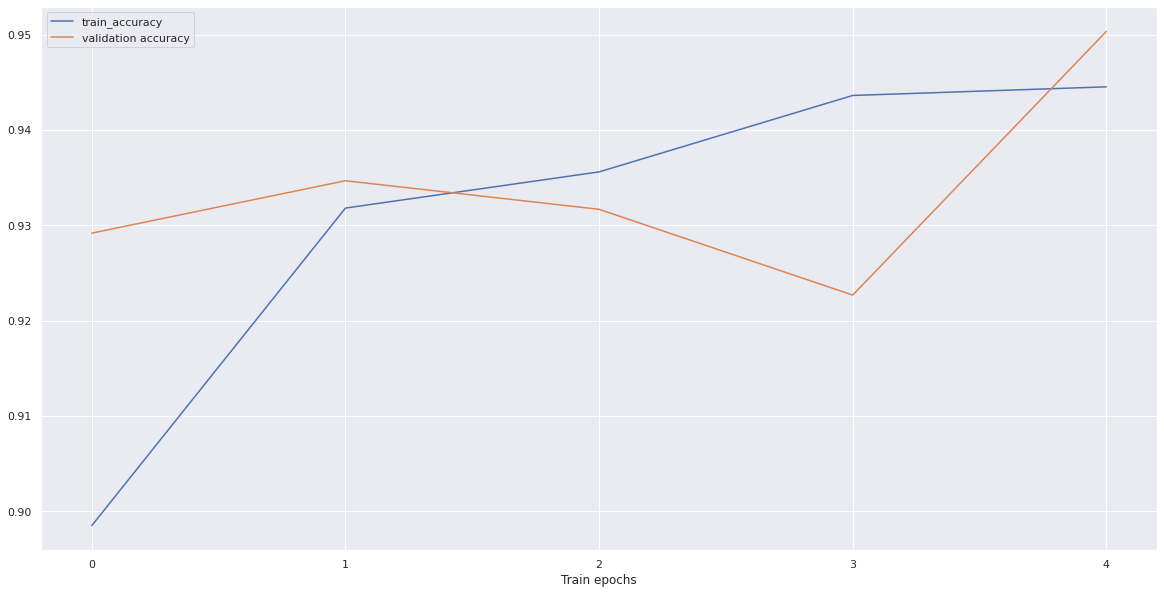

Test Accuracy: 0.9491
Total Parameters: 623290


In [ ]:
def train_and_evaluate(data = 'digits',
                       hidden_layer_sizes = [],
                       activation = 'tanh',
                       optimizer = 'Adam',
                       learning_rate = 0.01,
                       num_epochs = 5):

  # Build the model.
  model = build_model(n_classes = 10,
                      hidden_layer_sizes = hidden_layer_sizes,
                      activation = activation,
                      optimizer = optimizer,
                      learning_rate = learning_rate)

  # Select the dataset.
  if data == 'digits':
    X_train = X_train_digits
    X_test = X_test_digits
    Y_train = Y_train_digits
    Y_test = Y_test_digits
  elif data == 'fashion':
    X_train = X_train_fashion
    X_test = X_test_fashion
    Y_train = Y_train_fashion
    Y_test = Y_test_fashion
  else:
    raise 'Unsupported dataset: %s' %data

  # Train the model.
  print('Training...')
  #history = model.fit(x = X_train,
  #  y = Y_train, epochs=10, validation_split = 0.1)
  
  history = model.fit(
    x = X_train,
    y = Y_train,
    epochs = num_epochs,
    batch_size = 64,
    validation_split = 0.1,
    verbose = 0)
  
  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.
  plt.rcParams["figure.figsize"] = (20,10)
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label = 'train_accuracy')
  plt.plot(val_accuracy, label = 'validation accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  test_accuracy = model.evaluate(x = X_test, y = Y_test, verbose = 0,
                                 return_dict = True)['accuracy']
  total_parameters = count_params(model.trainable_weights)
  return test_accuracy, total_parameters

test_accuracy, total_parameters = train_and_evaluate()
print('Test Accuracy: %1.4f' %test_accuracy)
print('Total Parameters: %1.0f' %total_parameters)

---
### Exercise 2 (8 points)

Run experiments and fill in the test results in the table below. Feel free to extend the table to more experiments as you see fit.

*********************

Parameters used:  ['digits', [], 'tanh', 'SGD', 0.01]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 intermediate_layer (Dense)  (None, 784)               615440    
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'intermediate_layer')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Ou

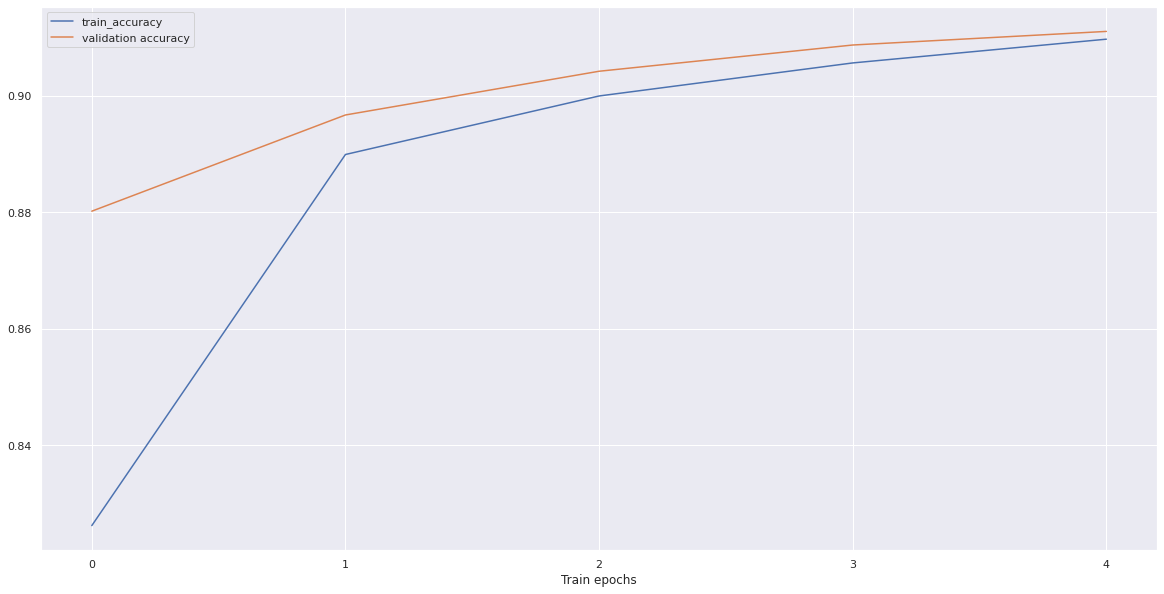

Test Accuracy: 0.9160
Total Parameters: 623290
*********************

Parameters used:  ['digits', [], 'relu', 'SGD', 0.01]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 intermediate_layer (Dense)  (None, 784)               615440    
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'intermediate_layer')>, <KerasTensor: shape

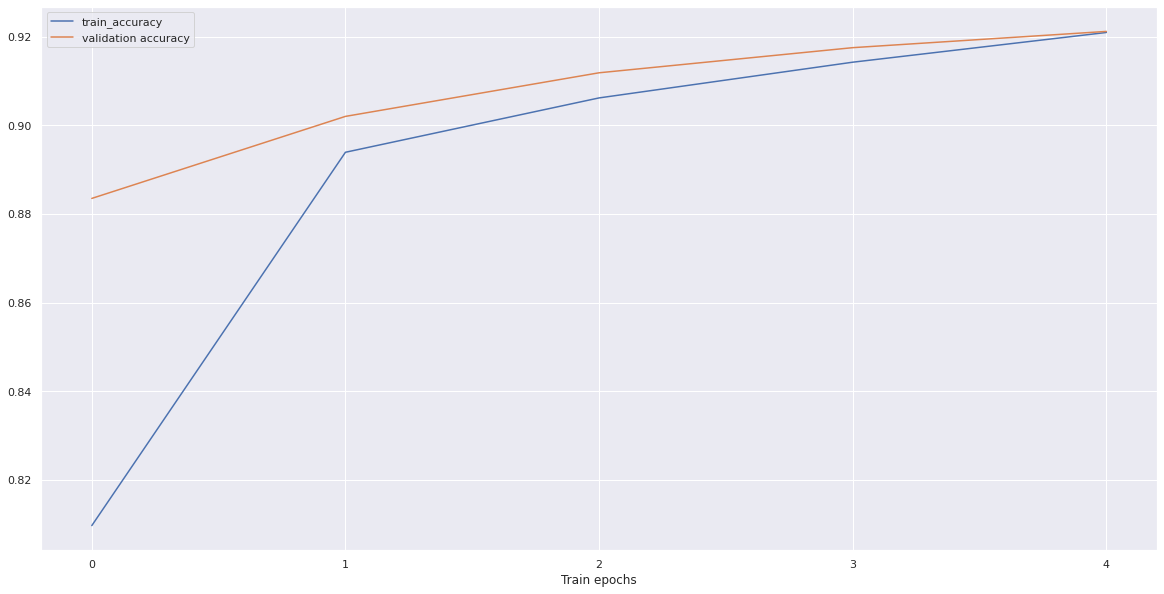

Test Accuracy: 0.9285
Total Parameters: 623290
*********************

Parameters used:  ['digits', [], 'relu', 'Adam', 0.01]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 intermediate_layer (Dense)  (None, 784)               615440    
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'intermediate_layer')>, <KerasTensor: shap

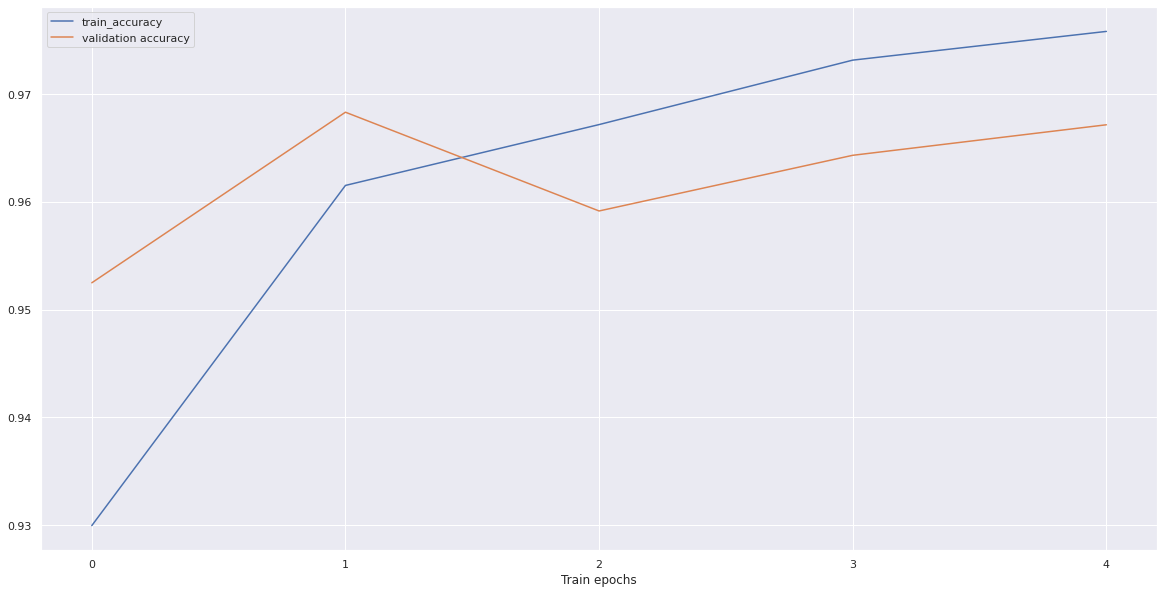

Test Accuracy: 0.9688
Total Parameters: 623290
*********************

Parameters used:  ['digits', [128], 'relu', 'Adam', 0.01]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 intermediate_layer (Dense)  (None, 784)               615440    
                                                                 
 fc_1 (Dense)                (None, 128)               100480    
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 717,210
Trainable params: 717,210
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (c

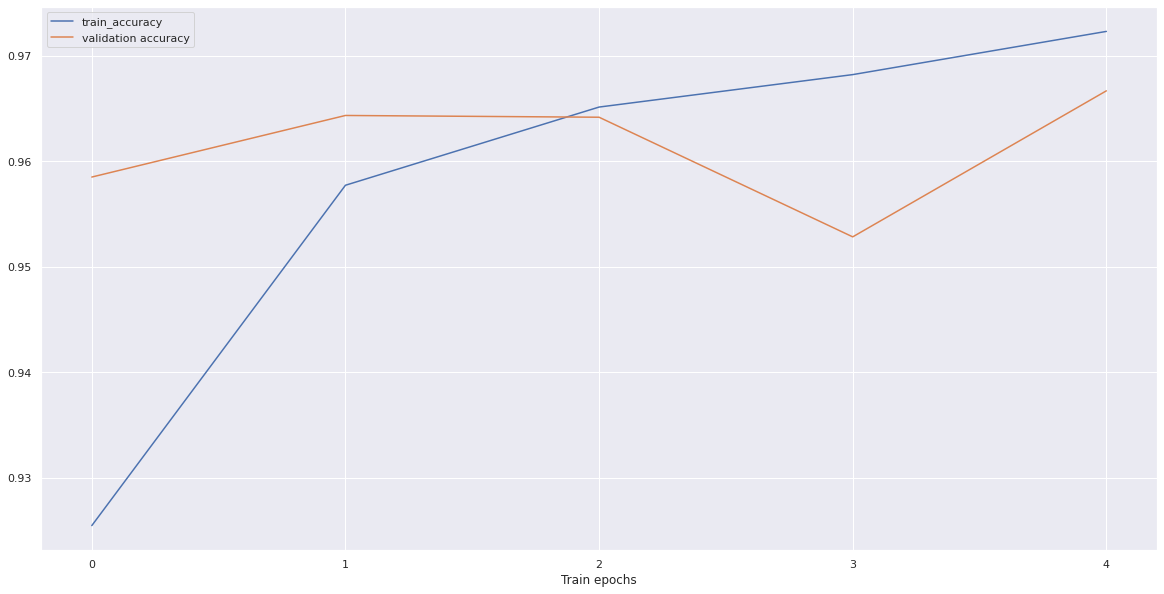

Test Accuracy: 0.9639
Total Parameters: 717210
*********************

Parameters used:  ['digits', [256, 128], 'relu', 'Adam', 0.01]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 intermediate_layer (Dense)  (None, 784)               615440    
                                                                 
 fc_1 (Dense)                (None, 256)               200960    
                                                                 
 fc_2 (Dense)                (None, 128)               32896     
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 850,586
Trainable params: 850,586
Non-tra

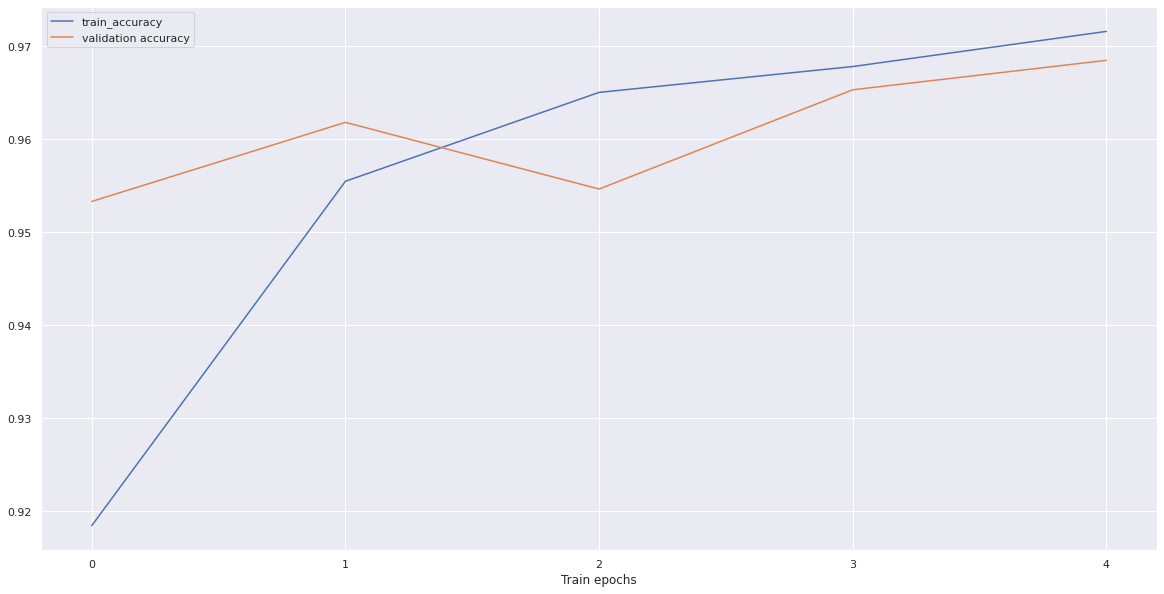

Test Accuracy: 0.9659
Total Parameters: 850586
*********************

Parameters used:  ['fashion', [], 'tanh', 'SGD', 0.01]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 intermediate_layer (Dense)  (None, 784)               615440    
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'intermediate_layer')>, <KerasTensor: shap

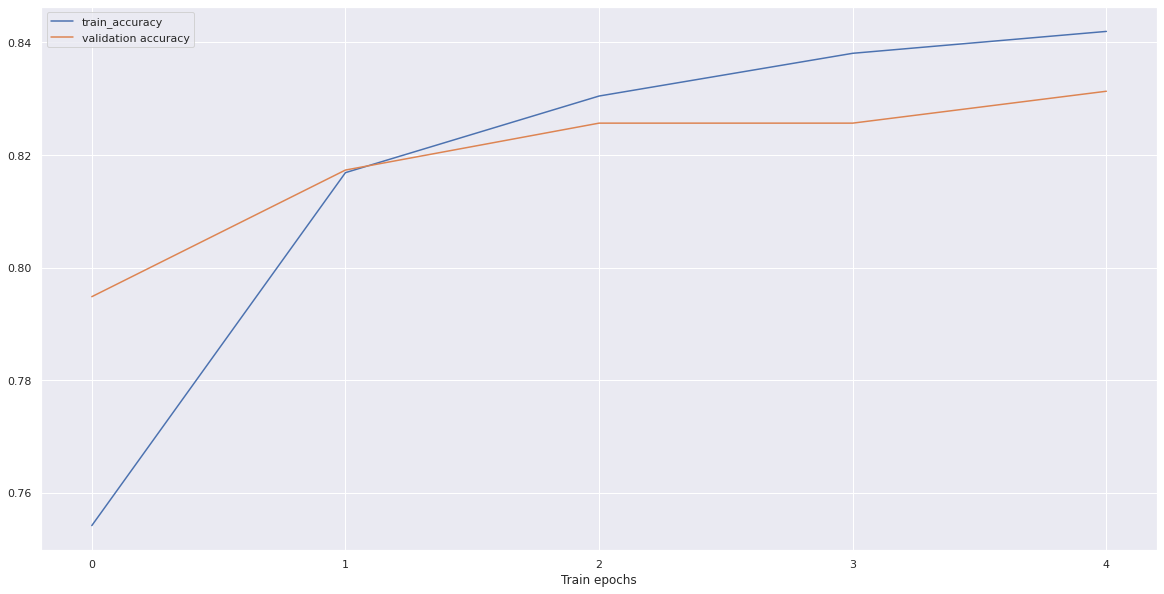

Test Accuracy: 0.8302
Total Parameters: 623290
*********************

Parameters used:  ['fashion', [], 'relu', 'SGD', 0.01]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 intermediate_layer (Dense)  (None, 784)               615440    
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'intermediate_layer')>, <KerasTensor: shap

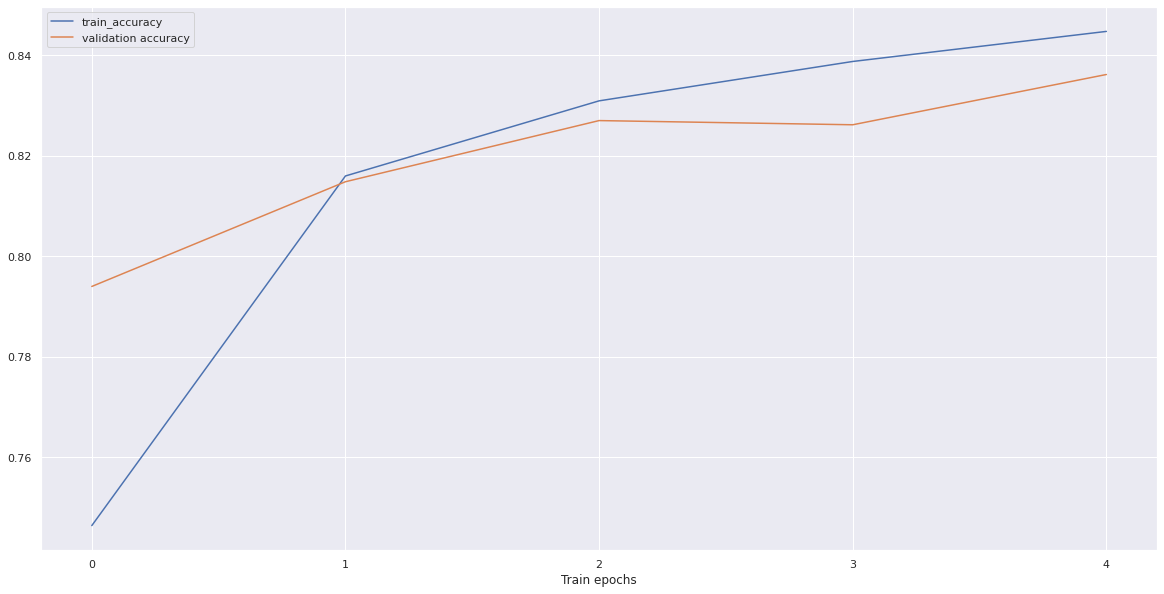

Test Accuracy: 0.8345
Total Parameters: 623290
*********************

Parameters used:  ['fashion', [], 'relu', 'Adam', 0.01]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 intermediate_layer (Dense)  (None, 784)               615440    
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'intermediate_layer')>, <KerasTensor: sha

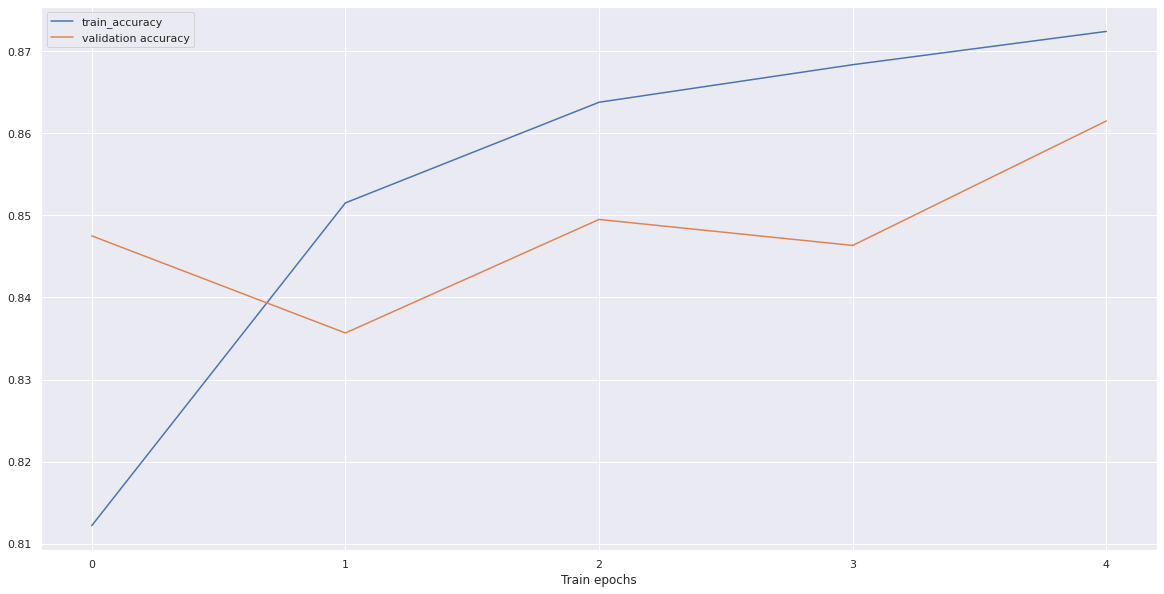

Test Accuracy: 0.8579
Total Parameters: 623290
*********************

Parameters used:  ['fashion', [128], 'relu', 'Adam', 0.01]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 intermediate_layer (Dense)  (None, 784)               615440    
                                                                 
 fc_1 (Dense)                (None, 128)               100480    
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 717,210
Trainable params: 717,210
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (

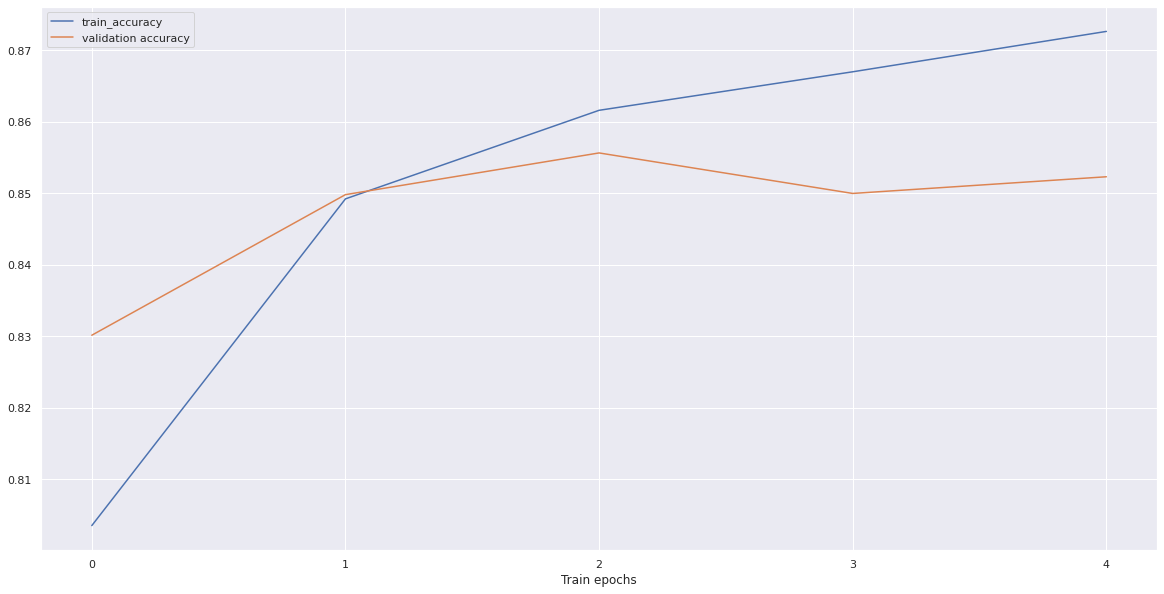

Test Accuracy: 0.8544
Total Parameters: 717210
*********************

Parameters used:  ['fashion', [256, 128], 'relu', 'Adam', 0.01]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 intermediate_layer (Dense)  (None, 784)               615440    
                                                                 
 fc_1 (Dense)                (None, 256)               200960    
                                                                 
 fc_2 (Dense)                (None, 128)               32896     
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 850,586
Trainable params: 850,586
Non-tr

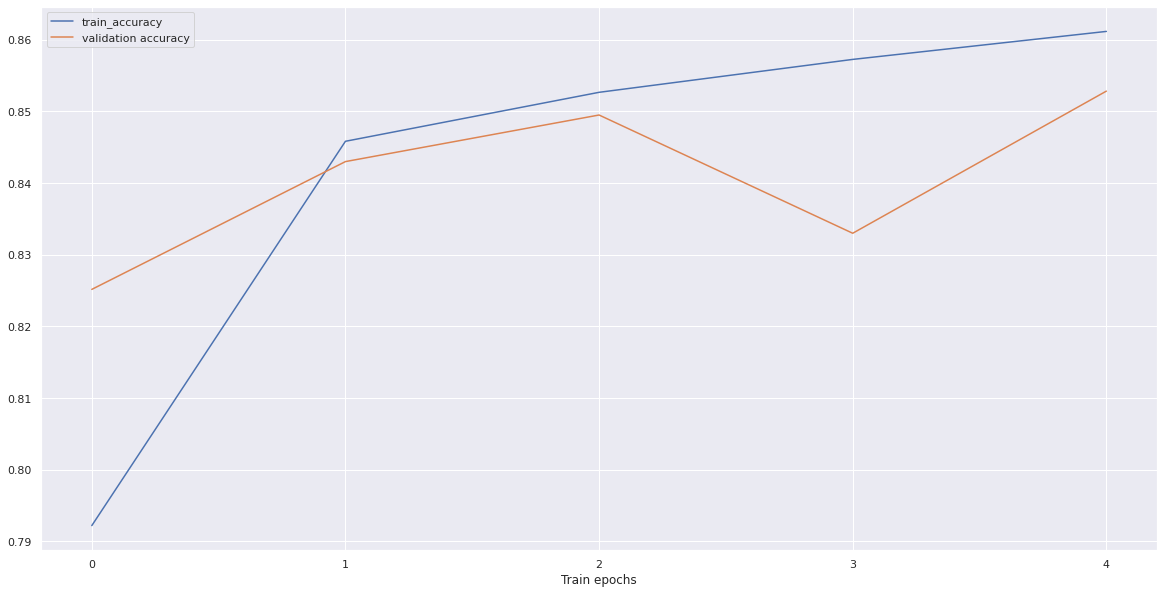

Test Accuracy: 0.8490
Total Parameters: 850586
*********************

Parameters used:  ['digits', [128], 'tanh', 'SGD', 0.01]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 intermediate_layer (Dense)  (None, 784)               615440    
                                                                 
 fc_1 (Dense)                (None, 128)               100480    
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 717,210
Trainable params: 717,210
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (cr

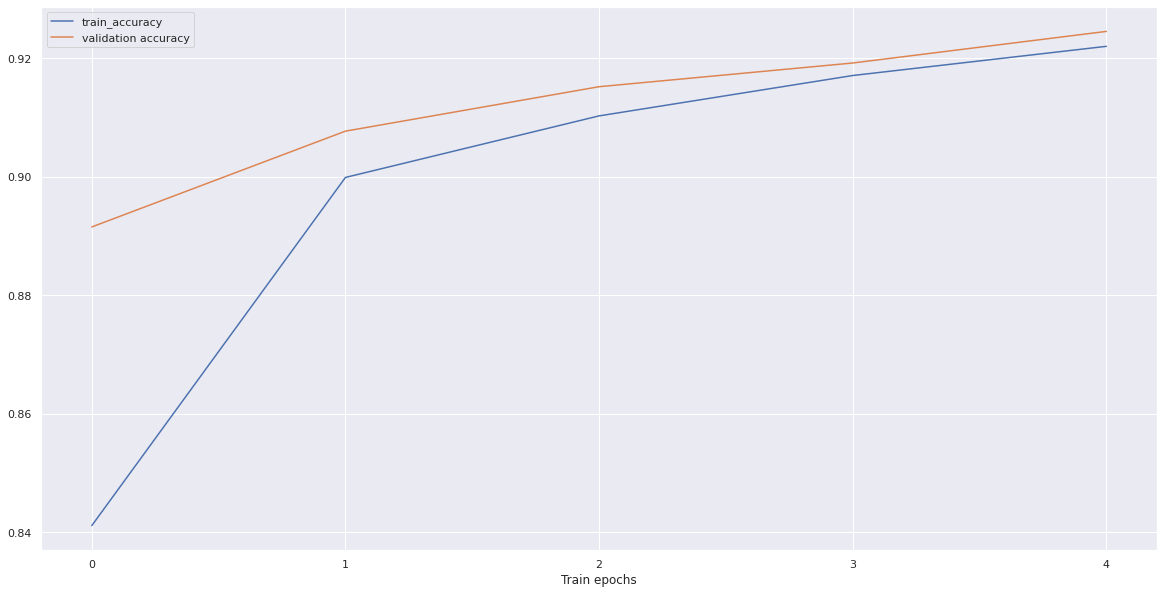

Test Accuracy: 0.9272
Total Parameters: 717210
*********************

Parameters used:  ['digits', [128], 'relu', 'SGD', 0.001]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 intermediate_layer (Dense)  (None, 784)               615440    
                                                                 
 fc_1 (Dense)                (None, 128)               100480    
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 717,210
Trainable params: 717,210
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (c

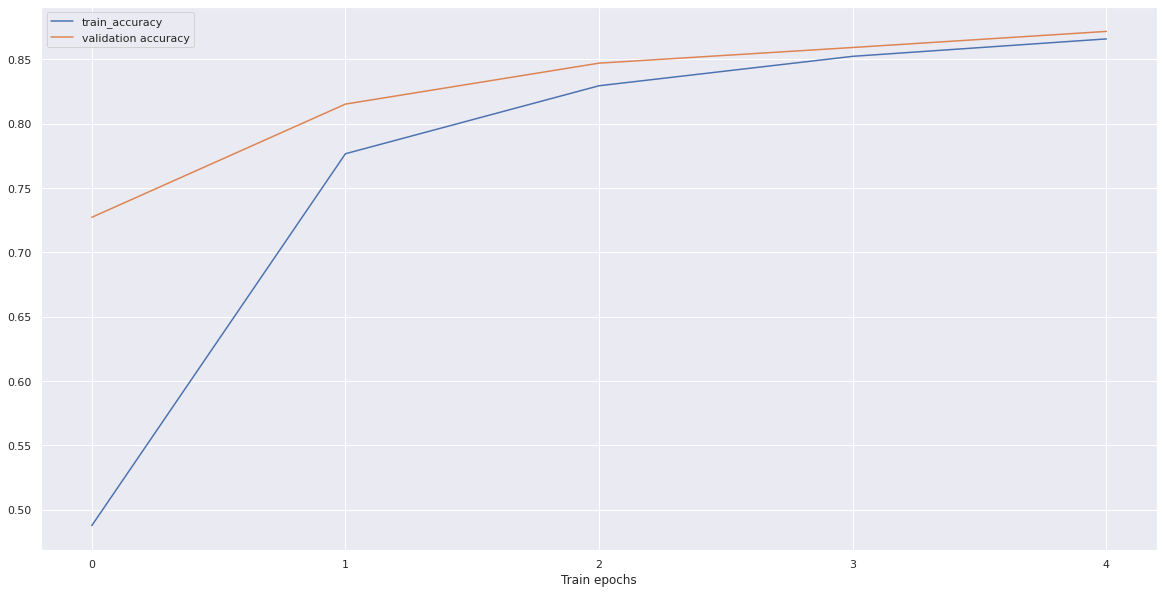

Test Accuracy: 0.8817
Total Parameters: 717210
*********************

Parameters used:  ['fashion', [128], 'relu', 'SGD', 0.01]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 intermediate_layer (Dense)  (None, 784)               615440    
                                                                 
 fc_1 (Dense)                (None, 128)               100480    
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 717,210
Trainable params: 717,210
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (c

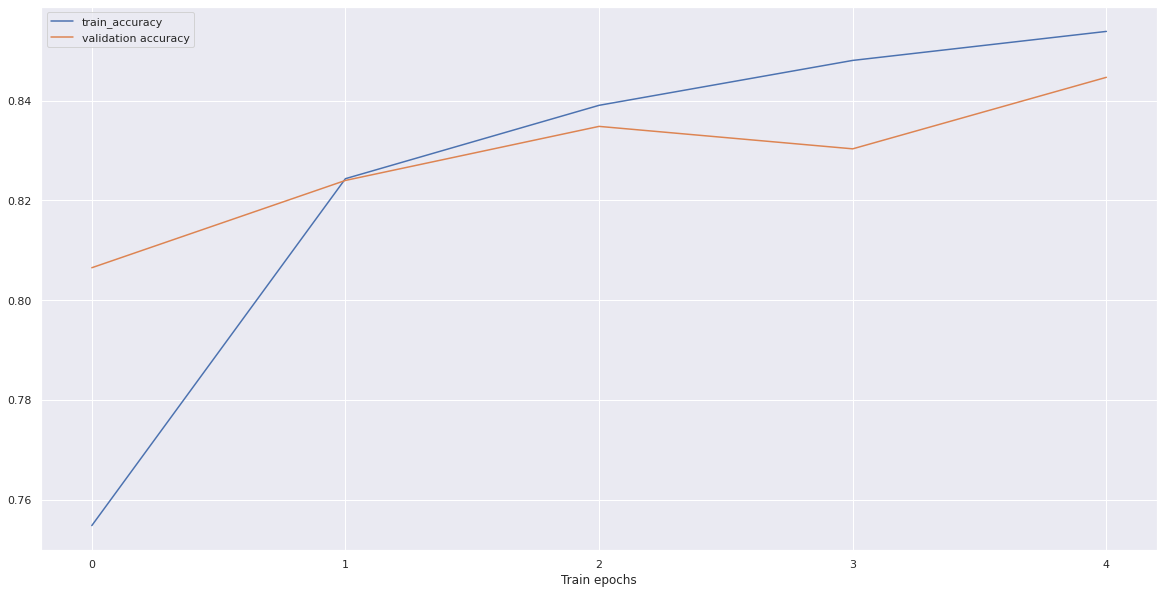

Test Accuracy: 0.8421
Total Parameters: 717210
*********************

Parameters used:  ['fashion', [256, 128], 'relu', 'SGD', 0.01]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 intermediate_layer (Dense)  (None, 784)               615440    
                                                                 
 fc_1 (Dense)                (None, 256)               200960    
                                                                 
 fc_2 (Dense)                (None, 128)               32896     
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 850,586
Trainable params: 850,586
Non-tra

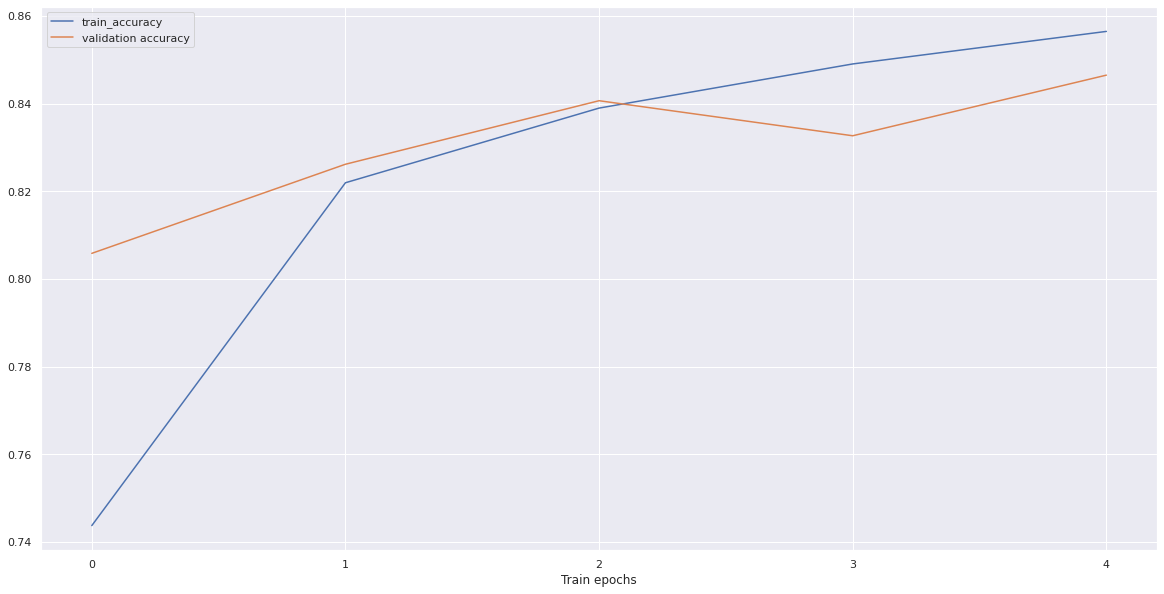

Test Accuracy: 0.8437
Total Parameters: 850586
*********************

Parameters used:  ['fashion', [128], 'tanh', 'SGD', 0.01]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 intermediate_layer (Dense)  (None, 784)               615440    
                                                                 
 fc_1 (Dense)                (None, 128)               100480    
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 717,210
Trainable params: 717,210
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (c

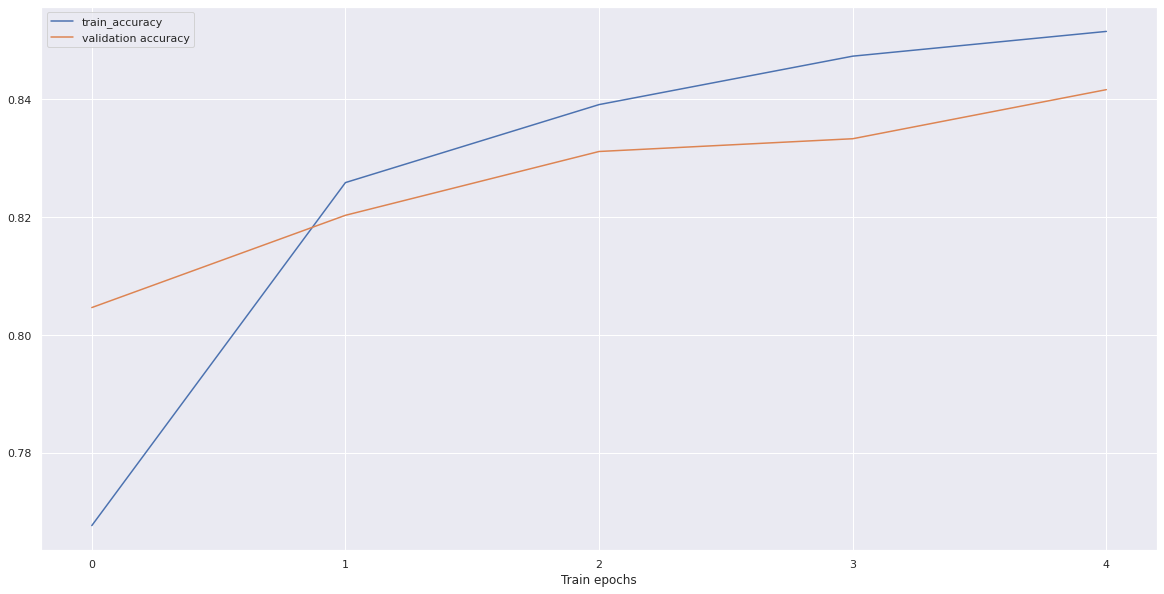

Test Accuracy: 0.8388
Total Parameters: 717210
*********************

Parameters used:  ['fashion', [256, 128], 'tanh', 'SGD', 0.01]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 intermediate_layer (Dense)  (None, 784)               615440    
                                                                 
 fc_1 (Dense)                (None, 256)               200960    
                                                                 
 fc_2 (Dense)                (None, 128)               32896     
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 850,586
Trainable params: 850,586
Non-tra

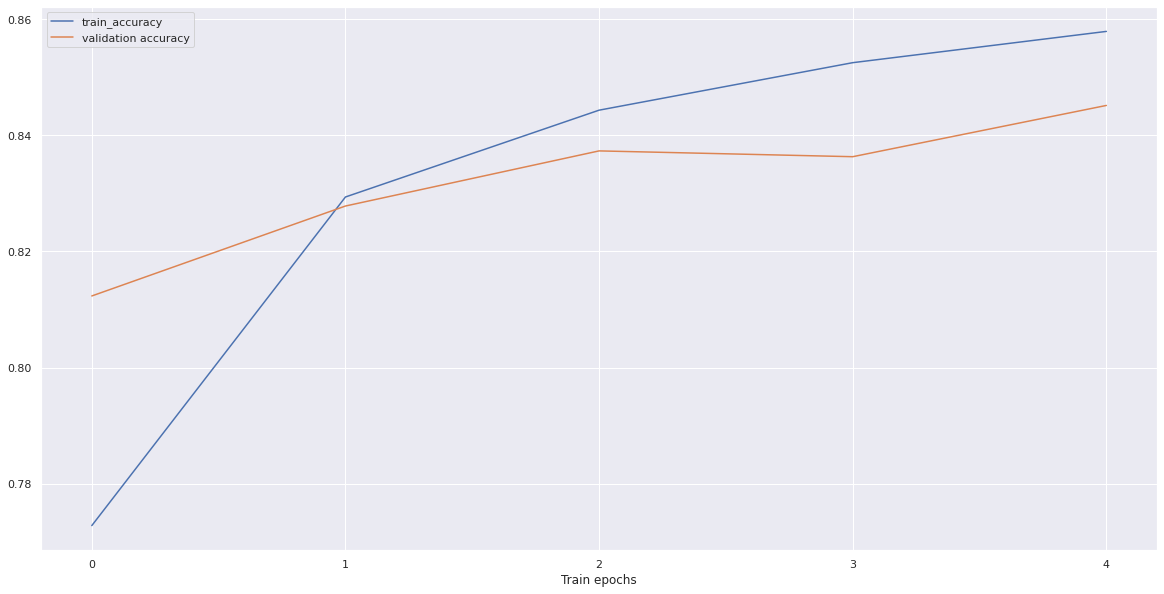

Test Accuracy: 0.8461
Total Parameters: 850586


In [200]:
param_list = [
['digits',[],'tanh','SGD',0.01],
['digits',[],'relu','SGD',0.01],
['digits',[],'relu','Adam',0.01],
['digits',[128],'relu','Adam',0.01],
['digits',[256,128],'relu','Adam',0.01],

['fashion',[],'tanh','SGD',0.01],
['fashion',[],'relu','SGD',0.01],
['fashion',[],'relu','Adam',0.01],
['fashion',[128],'relu','Adam',0.01],
['fashion',[256,128],'relu','Adam',0.01],

### My Addition ###
## Trying to test more with SGD over Adam ##
['digits',[128],'tanh','SGD',0.01],
['digits',[128],'relu','SGD',0.001],
['fashion',[128],'relu','SGD',0.01],
['fashion',[256,128],'relu','SGD',0.01],
['fashion',[128],'tanh','SGD',0.01],
['fashion',[256,128],'tanh','SGD',0.01]
]

output_list = []
for param in param_list:
    print("*********************")
    print()
    print("Parameters used: ",param)
    test_accuracy, total_parameters = train_and_evaluate(data = param[0],
                                                     hidden_layer_sizes = param[1],
                                                     activation = param[2],
                                                     optimizer = param[3],
                                                     learning_rate = param[4],
                                                     num_epochs = 5 
                                                    )
    print('Test Accuracy: %1.4f' %test_accuracy)
    print('Total Parameters: %1.0f' %total_parameters)
    str1 = (str(param).replace("'","")[1:-1].replace(", [","|[").replace("], ","]|").split("|")[0] + "|" +
            str(param).replace("'","")[1:-1].replace(", [","|[").replace("], ","]|").split("|")[1] + "|" +
            str(param).replace("'","")[1:-1].replace(", [","|[").replace("], ","]|").split("|")[2].replace(", ","|"))
    str2 = str([total_parameters,test_accuracy]).replace(", ","|").replace("]","").replace("[","")
    output_list.append((str1, str2))

In [210]:
print("DATA | HIDDEN SIZES | ACTIVATION | OPTIMIZER | LEARNING RATE | #PARAMETERS | TEST ACCURACY")
print("-|-|-|-|-|-|-")
for entry in output_list:
    print(str(entry).replace("('","").replace(")","").replace("', '","|").replace("'",""))

DATA | HIDDEN SIZES | ACTIVATION | OPTIMIZER | LEARNING RATE | #PARAMETERS | TEST ACCURACY
-|-|-|-|-|-|-
digits|[]|tanh|SGD|0.01|623290|0.9160000085830688
digits|[]|relu|SGD|0.01|623290|0.9284999966621399
digits|[]|relu|Adam|0.01|623290|0.9688000082969666
digits|[128]|relu|Adam|0.01|717210|0.9639000296592712
digits|[256, 128]|relu|Adam|0.01|850586|0.9659000039100647
fashion|[]|tanh|SGD|0.01|623290|0.8302000164985657
fashion|[]|relu|SGD|0.01|623290|0.8345000147819519
fashion|[]|relu|Adam|0.01|623290|0.8579000234603882
fashion|[128]|relu|Adam|0.01|717210|0.8543999791145325
fashion|[256, 128]|relu|Adam|0.01|850586|0.8489999771118164
digits|[128]|tanh|SGD|0.01|717210|0.9272000193595886
digits|[128]|relu|SGD|0.001|717210|0.8816999793052673
fashion|[128]|relu|SGD|0.01|717210|0.8421000242233276
fashion|[256, 128]|relu|SGD|0.01|850586|0.8436999917030334
fashion|[128]|tanh|SGD|0.01|717210|0.8388000130653381
fashion|[256, 128]|tanh|SGD|0.01|850586|0.8460999727249146


#### Student Solution

DATA | HIDDEN SIZES | ACTIVATION | OPTIMIZER | LEARNING RATE | #PARAMETERS | TEST ACCURACY
-|-|-|-|-|-|-
digits|[]|tanh|SGD|0.01|623290|0.9160000085830688
digits|[]|relu|SGD|0.01|623290|0.9284999966621399
digits|[]|relu|Adam|0.01|623290|0.9688000082969666
digits|[128]|relu|Adam|0.01|717210|0.9639000296592712
digits|[256, 128]|relu|Adam|0.01|850586|0.9659000039100647
-
fashion|[]|tanh|SGD|0.01|623290|0.8302000164985657
fashion|[]|relu|SGD|0.01|623290|0.8345000147819519
fashion|[]|relu|Adam|0.01|623290|0.8579000234603882
fashion|[128]|relu|Adam|0.01|717210|0.8543999791145325
fashion|[256, 128]|relu|Adam|0.01|850586|0.8489999771118164
-
-
digits|[128]|tanh|SGD|0.01|717210|0.9272000193595886
digits|[128]|relu|SGD|0.001|717210|0.8816999793052673
fashion|[128]|relu|SGD|0.01|717210|0.8421000242233276
fashion|[256, 128]|relu|SGD|0.01|850586|0.8436999917030334
fashion|[128]|tanh|SGD|0.01|717210|0.8388000130653381
fashion|[256, 128]|tanh|SGD|0.01|850586|0.8460999727249146